[INFO] Failure number 1
[INFO] Failure number 2
[INFO] Failure number 3
[INFO] Failure number 4
[INFO] Failure number 5
[INFO] Failure number 6
[INFO] Failure number 7
[INFO] Failure number 8
[INFO] Failure number 9
[INFO] Failure number 10
[INFO] Failure number 11
[INFO] Failure number 12
[INFO] Failure number 13
[INFO] Failure number 14
[INFO] Failure number 15
[INFO] Failure number 16
[INFO] Failure number 17
[INFO] Failure number 18
[INFO] Failure number 19
[INFO] Failure number 20
[INFO] Failure number 21
[INFO] Failure number 22
[INFO] Failure number 23
[INFO] Failure number 24
[INFO] Failure number 25
[INFO] Failure number 26
[INFO] Failure number 27
[INFO] Failure number 28
[INFO] Failure number 29
[INFO] Failure number 30
[INFO] Failure number 31
[INFO] Failure number 32
[INFO] Failure number 33
[INFO] Failure number 34
[INFO] Failure number 35
[INFO] Failure number 36
[INFO] Failure number 37
[INFO] Failure number 38
[INFO] Failure number 39
[INFO] Failure number 40
[INFO] Fa

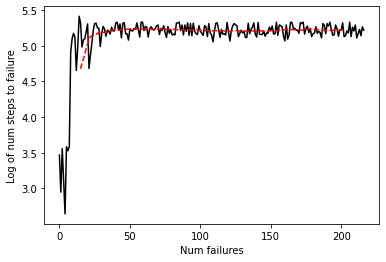

In [14]:
"""
CS 229 Machine Learning
Question: Reinforcement Learning - The Inverted Pendulum
"""
from __future__ import division, print_function
from env import CartPole, Physics
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter

"""
Parts of the code (cart and pole dynamics, and the state
discretization) are inspired from code available at the RL repository
http://www-anw.cs.umass.edu/rlr/domains.html

Briefly, the cart-pole system is described in `cart_pole.py`. The main
simulation loop in this file calls the `simulate()` function for
simulating the pole dynamics, `get_state()` for discretizing the
otherwise continuous state space in discrete states, and `show_cart()`
for display.

Some useful parameters are listed below:

`NUM_STATES`: Number of states in the discretized state space
You must assume that states are numbered 0 through `NUM_STATES` - 1. The
state numbered `NUM_STATES` - 1 (the last one) is a special state that
marks the state when the pole has been judged to have fallen (or when
the cart is out of bounds). However, you should NOT treat this state
any differently in your code. Any distinctions you need to make between
states should come automatically from your learning algorithm.

After each simulation cycle, you are supposed to update the transition
counts and rewards observed. However, you should not change either
your value function or the transition probability matrix at each
cycle.

Whenever the pole falls, a section of your code below will be
executed. At this point, you must use the transition counts and reward
observations that you have gathered to generate a new model for the MDP
(i.e. transition probabilities and state rewards). After that, you
must use value iteration to get the optimal value function for this MDP
model.

`TOLERANCE`: Controls the convergence criteria for each value iteration
run. In value iteration, you can assume convergence when the maximum
absolute change in the value function at any state in an iteration
becomes lower than `TOLERANCE.

You need to write code that chooses the best action according
to your current value function, and the current model of the MDP. The
action must be either 0 or 1 (corresponding to possible directions of
pushing the cart)

Finally, we assume that the simulation has converged when
`NO_LEARNING_THRESHOLD` consecutive value function computations all
converged within one value function iteration. Intuitively, it seems
like there will be little learning after this, so we end the simulation
here, and say the overall algorithm has converged.


Learning curves can be generated by calling a code snippet at the end
(it assumes that the learning was just executed, and the array
`time_steps_to_failure` that records the time for which the pole was
balanced before each failure is in memory). `num_failures` is a variable
that stores the number of failures (pole drops / cart out of bounds)
till now.

Other parameters in the code are described below:

`GAMMA`: Discount factor to be used

The following parameters control the simulation display; you dont
really need to know about them:

`pause_time`: Controls the pause between successive frames of the
display. Higher values make your simulation slower.
`min_trial_length_to_start_display`: Allows you to start the display only
after the pole has been successfully balanced for at least this many
trials. Setting this to zero starts the display immediately. Choosing a
reasonably high value (around 100) can allow you to rush through the
initial learning quickly, and start the display only after the
performance is reasonable.
"""

def initialize_mdp_data(num_states):
    """
    Return a variable that contains all the parameters/state you need for your MDP.
    Feel free to use whatever data type is most convenient for you (custom classes, tuples, dicts, etc)

    Assume that no transitions or rewards have been observed.
    Initialize the value function array to small random values (0 to 0.10, say).
    Initialize the transition probabilities uniformly (ie, probability of
        transitioning for state x to state y using action a is exactly
        1/num_states).
    Initialize all state rewards to zero.

    Args:
        num_states: The number of states

    Returns: The initial MDP parameters
    """
    transition_counts = np.zeros((num_states, num_states, 2))
    transition_probs = np.ones((num_states, num_states, 2)) / num_states
    reward_counts = np.zeros((num_states, 2))
    reward = np.zeros(num_states)
    value = np.random.rand(num_states) * 0.1

    return {
        'transition_counts': transition_counts,
        'transition_probs': transition_probs,
        'reward_counts': reward_counts,
        'reward': reward,
        'value': value,
        'num_states': num_states,
    }

def choose_action(state, mdp_data):
    """
    Choose the next action (0 or 1) that is optimal according to your current
    mdp_data. When there is no optimal action, return a random action.

    Args:
        state: The current state in the MDP
        mdp_data: The parameters for your MDP. See initialize_mdp_data.

    Returns:
        0 or 1 that is optimal according to your current MDP
    """

    # *** START CODE HERE ***
    TP = mdp_data['transition_probs'][state]
    PV = np.matmul(TP.T, mdp_data['value'])
    return int(np.random.rand() > 0.5) if PV[0] == PV[1] else np.argmax(PV)
    # *** END CODE HERE ***

def update_mdp_transition_counts_reward_counts(mdp_data, state, action, new_state, reward):
    """
    Update the transition count and reward count information in your mdp_data. 
    Do not change the other MDP parameters (those get changed later).

    Record the number of times `state, action, new_state` occurs.
    Record the rewards for every `new_state`.
    Record the number of time `new_state` was reached.

    Args:
        mdp_data: The parameters of your MDP. See initialize_mdp_data.
        state: The state that was observed at the start.
        action: The action you performed.
        new_state: The state after your action.
        reward: The reward after your action (i.e. reward corresponding to new_state).

    Returns:
        Nothing
    """

    # *** START CODE HERE ***
    #print(mdp_data['transition_counts'][state, :, action])

    mdp_data['transition_counts'][state, new_state, action] += 1
    mdp_data['reward_counts'][new_state, 0] += reward
    mdp_data['reward_counts'][new_state, 1] += 1

    #print(state, action, new_state, mdp_data['transition_counts'][state, :, action])

    # *** END CODE HERE ***

    # This function does not return anything
    return

def update_mdp_transition_probs_reward(mdp_data):
    """
    Update the estimated transition probabilities and reward values in your MDP.

    Make sure you account for the case when a state-action pair has never
    been tried before, or the state has never been visited before. In that
    case, you must not change that component (and thus keep it at the
    initialized uniform distribution).
    
    Args:
        mdp_data: The data for your MDP. See initialize_mdp_data.

    Returns:
        Nothing

    """

    # *** START CODE HERE ***

    num_states = mdp_data['num_states']
    actions = 2
    transition_counts = mdp_data["transition_counts"]
    reward_counts = mdp_data['reward_counts']

    for state in range(num_states):

        for action in range(actions):
            if np.sum(transition_counts[state, :, action]) == 0:
                continue

            denom = np.sum(transition_counts[state, :, action])
            for new_state in range(num_states):
                mdp_data["transition_probs"][state, new_state, action] = transition_counts[state, new_state, action] / denom

        if reward_counts[state, 1] == 0:
            continue
        mdp_data['reward'][state] = reward_counts[state, 0] / reward_counts[state, 1]


    # *** END CODE HERE ***

    # This function does not return anything
    return

def update_mdp_value(mdp_data, tolerance, gamma):
    """
    Update the estimated values in your MDP.


    Perform value iteration using the new estimated model for the MDP.
    The convergence criterion should be based on `TOLERANCE` as described
    at the top of the file.

    Return true if it converges within one iteration.
    
    Args:
        mdp_data: The data for your MDP. See initialize_mdp_data.
        tolerance: The tolerance to use for the convergence criterion.
        gamma: Your discount factor.

    Returns:
        True if the value iteration converged in one iteration

    """
    # *** START CODE HERE ***
    i = 0
    new_value = mdp_data['value'].copy()
    num_states = mdp_data["num_states"]
    while True:
        prev_value = new_value.copy()
        for state in range(num_states):
            state_reward = mdp_data['reward'][state]
            new_value[state] = state_reward + gamma * np.max(np.dot(mdp_data['transition_probs'][state].T, prev_value))

        i += 1

        if np.max(np.abs(new_value - prev_value)) < tolerance:
            mdp_data['value'] = new_value

            if i == 1:
                return True
            else:
                break

    # *** END CODE HERE ***

def main(plot=True):
    # Seed the randomness of the simulation so this outputs the same thing each time
    np.random.seed(3)

    # Simulation parameters
    pause_time = 0.0001
    min_trial_length_to_start_display = 100
    display_started = min_trial_length_to_start_display == 0

    NUM_STATES = 163
    GAMMA = 0.995
    TOLERANCE = 0.01
    NO_LEARNING_THRESHOLD = 20

    # Time cycle of the simulation
    time = 0

    # These variables perform bookkeeping (how many cycles was the pole
    # balanced for before it fell). Useful for plotting learning curves.
    time_steps_to_failure = []
    num_failures = 0
    time_at_start_of_current_trial = 0

    # You should reach convergence well before this
    max_failures = 500

    # Initialize a cart pole
    cart_pole = CartPole(Physics())

    # Starting `state_tuple` is (0, 0, 0, 0)
    # x, x_dot, theta, theta_dot represents the actual continuous state vector
    x, x_dot, theta, theta_dot = 0.0, 0.0, 0.0, 0.0
    state_tuple = (x, x_dot, theta, theta_dot)

    # `state` is the number given to this state, you only need to consider
    # this representation of the state
    state = cart_pole.get_state(state_tuple)
    # if min_trial_length_to_start_display == 0 or display_started == 1:
    #     cart_pole.show_cart(state_tuple, pause_time)

    mdp_data = initialize_mdp_data(NUM_STATES)

    # This is the criterion to end the simulation.
    # You should change it to terminate when the previous
    # 'NO_LEARNING_THRESHOLD' consecutive value function computations all
    # converged within one value function iteration. Intuitively, it seems
    # like there will be little learning after this, so end the simulation
    # here, and say the overall algorithm has converged.

    consecutive_no_learning_trials = 0
    while consecutive_no_learning_trials < NO_LEARNING_THRESHOLD:

        action = choose_action(state, mdp_data)

        # Get the next state by simulating the dynamics
        state_tuple = cart_pole.simulate(action, state_tuple)
        # x, x_dot, theta, theta_dot = state_tuple

        # Increment simulation time
        time = time + 1

        # Get the state number corresponding to new state vector
        new_state = cart_pole.get_state(state_tuple)
        # if display_started == 1:
        #     cart_pole.show_cart(state_tuple, pause_time)

        # reward function to use - do not change this!
        if new_state == NUM_STATES - 1:
            R = -1
        else:
            R = 0

        update_mdp_transition_counts_reward_counts(mdp_data, state, action, new_state, R)

        # Recompute MDP model whenever pole falls
        # Compute the value function V for the new model
        if new_state == NUM_STATES - 1:

            update_mdp_transition_probs_reward(mdp_data)

            converged_in_one_iteration = update_mdp_value(mdp_data, TOLERANCE, GAMMA)

            if converged_in_one_iteration:
                consecutive_no_learning_trials = consecutive_no_learning_trials + 1
            else:
                consecutive_no_learning_trials = 0

        # Do NOT change this code: Controls the simulation, and handles the case
        # when the pole fell and the state must be reinitialized.
        if new_state == NUM_STATES - 1:
            num_failures += 1
            if num_failures >= max_failures:
                break
            print('[INFO] Failure number {}'.format(num_failures))
            time_steps_to_failure.append(time - time_at_start_of_current_trial)
            # time_steps_to_failure[num_failures] = time - time_at_start_of_current_trial
            time_at_start_of_current_trial = time

            if time_steps_to_failure[num_failures - 1] > min_trial_length_to_start_display:
                display_started = 1

            # Reinitialize state
            # x = 0.0
            x = -1.1 + np.random.uniform() * 2.2
            x_dot, theta, theta_dot = 0.0, 0.0, 0.0
            state_tuple = (x, x_dot, theta, theta_dot)
            state = cart_pole.get_state(state_tuple)
        else:
            state = new_state

    if plot:
        # plot the learning curve (time balanced vs. trial)
        log_tstf = np.log(np.array(time_steps_to_failure))
        plt.plot(np.arange(len(time_steps_to_failure)), log_tstf, 'k')
        window = 30
        w = np.array([1/window for _ in range(window)])
        weights = lfilter(w, 1, log_tstf)
        x = np.arange(window//2, len(log_tstf) - window//2)
        plt.plot(x, weights[window:len(log_tstf)], 'r--')
        plt.xlabel('Num failures')
        plt.ylabel('Log of num steps to failure')
        plt.savefig('./control.pdf')

    return np.array(time_steps_to_failure)

if __name__ == '__main__':
    main()